# 人脸图像识别-CNN

## 1. 数据预处理

## 1.1 数据读取

读取 faceDR 和 faceDS 文本文件，提取每张人脸的类别标签。
读取 rawdata 文件夹中的二进制图像数据，将每张图像转换为 128×128 的灰度图。

先读一个试试，根据doc中的提示，但不直接使用MATLAB软件，用matplotlib库代替

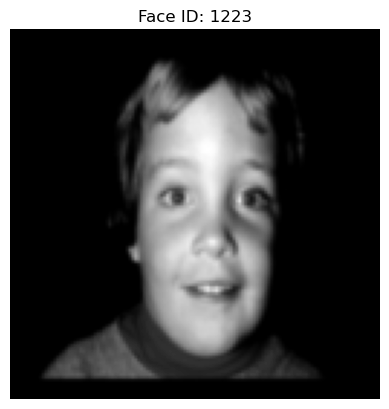

In [1]:
import numpy as np
import matplotlib.pyplot as plt

file_path = './data/rawdata/1223'
try:
    with open(file_path, 'rb') as f:
        # 读取二进制数据
        data = np.fromfile(f, dtype=np.uint8)
        # 重塑为 128x128
        image = data.reshape(128, 128)
        
        # 显示图像
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('Face ID: 1223')
        plt.show()

except FileNotFoundError:
    print(f'File {file_path} not found.')
except ValueError:
    print(f'File {file_path} contains invalid data.')


成功了，接下来正式加载数据并封装函数

### 1.1.1 标签解析

In [2]:
import pandas as pd
import re

def read_labels(file_path):
    labels = []
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            # 处理缺失数据
            if "_missing descriptor" in line:
                face_id = line.split()[0]
                labels.append({"id": face_id, "sex": None, "age": None, "race": None, "face": None, "prop": None})
            else:
                # 使用正则表达式提取信息
                face_id = line.split()[0]
                sex = re.search(r"\(_sex\s+(\w+)\)", line)
                age = re.search(r"\(_age\s+(\w+)\)", line)
                race = re.search(r"\(_race\s+(\w+)\)", line)
                face = re.search(r"\(_face\s+(\w+)\)", line)
                prop = re.search(r"\(_prop\s+'?\((.*?)\)?\)", line)

                labels.append({
                    "id": face_id,
                    "sex": sex.group(1) if sex else None,
                    "age": age.group(1) if age else None,
                    "race": race.group(1) if race else None,
                    "face": face.group(1) if face else None,
                    "prop": prop.group(1) if prop else None
                })

    # 转换为 Pandas DataFrame
    df = pd.DataFrame(labels)
    return df

# 示例：读取 faceDR 和 faceDS
faceDR_labels = read_labels('./data/faceDR.txt')
faceDS_labels = read_labels('./data/faceDS.txt')

In [3]:
# 查看数据
print(faceDR_labels.head())
print(faceDS_labels.head())

     id   sex    age   race     face prop
0  1223  male  child  white  smiling     
1  1224  male  child  white  serious     
2  1225  male  child  white  smiling     
3  1226  male  child  white  smiling     
4  1227  male  child  white  serious     
     id     sex     age   race     face  prop
0  3223  female  senior  black  smiling  hat 
1  3224  female   adult  black  smiling      
2  3225    male  senior  white  smiling      
3  3226    male  senior  white  serious      
4  3227    male  senior  white  serious      


### 1.1.2 图像数据

In [4]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def read_image(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = np.fromfile(f, dtype=np.uint8)  # 读取二进制数据
            if len(data) == 128 * 128:  # 确保数据尺寸匹配
                return data.reshape(128, 128).tolist()  # 转换为列表，方便存储到 DataFrame
            else:
                print(f"Invalid image data in file: {file_path}")
                return None
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

### 1.1.3 构建完整训练集与测试集

In [5]:
def add_images_to_labels(label_df, rawdata_folder):
    images = []  # 存储图像数据
    for face_id in label_df['id']:
        file_path = os.path.join(rawdata_folder, str(face_id))  # 构造图像路径
        image = read_image(file_path)
        images.append(image)
    
    # 将图像数据加入到 DataFrame
    label_df['image'] = images
    return label_df

rawdata_folder = './data/rawdata/'

# 构造训练集：faceDR + 图像数据
train_set = add_images_to_labels(faceDR_labels, rawdata_folder)

# 构造测试集：faceDS + 图像数据
test_set = add_images_to_labels(faceDS_labels, rawdata_folder)

File not found: ./data/rawdata/1228
File not found: ./data/rawdata/1232
File not found: ./data/rawdata/1808
Invalid image data in file: ./data/rawdata/2412
Invalid image data in file: ./data/rawdata/2416
File not found: ./data/rawdata/4056
File not found: ./data/rawdata/4135
File not found: ./data/rawdata/4136
File not found: ./data/rawdata/5004


### 1.1.4 展示数据集与图像

In [6]:
def visualize_images(dataframe, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        # 提取图像数据
        image = dataframe.iloc[i]['image']
        face_id = dataframe.iloc[i]['id']
        
        if image is not None:
            plt.subplot(1, num_images, i + 1)
            plt.imshow(np.array(image), cmap='gray')  # 将列表还原为矩阵
            plt.title(f"ID: {face_id}")
            plt.axis('off')
        else:
            print(f"No image data for ID: {face_id}")
    plt.show()

In [7]:
test_set

,id,sex,age,race,face,prop,image
0,3223,female,senior,black,smiling,hat,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,3224,female,adult,black,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3225,male,senior,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3226,male,senior,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,3227,male,senior,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...
1995,5218,female,adult,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1996,5219,female,adult,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1997,5220,female,adult,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1998,5221,female,adult,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [8]:
train_set

,id,sex,age,race,face,prop,image
0,1223,male,child,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1224,male,child,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1225,male,child,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1226,male,child,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1227,male,child,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...
1995,3218,female,senior,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1996,3219,female,senior,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1997,3220,female,adult,asian,serious,glasses,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1998,3221,female,senior,white,smiling,hat,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


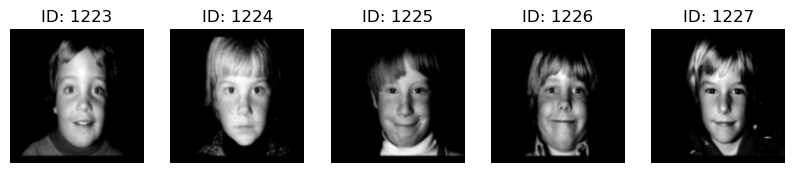

In [9]:
visualize_images(train_set, num_images=5)

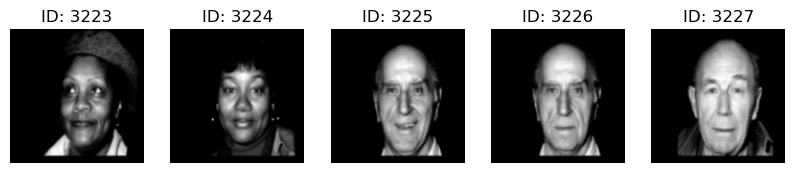

In [10]:
visualize_images(test_set, num_images=5)

## 1.2 数据清洗

主要是缺失值、错误值。错误值之前处理为None了

In [11]:
def clean_data(dataframe):
    cleaned_df = dataframe.dropna(subset=['image']).reset_index(drop=True)
    print(f"清洗完成：从 {len(dataframe)} 个样本中删除了 {len(dataframe) - len(cleaned_df)} 个缺失或错误样本。")
    return cleaned_df

# 清洗训练集和测试集
train_set_cleaned = clean_data(train_set)
test_set_cleaned = clean_data(test_set)

清洗完成：从 2000 个样本中删除了 5 个缺失或错误样本。
清洗完成：从 2000 个样本中删除了 4 个缺失或错误样本。


In [12]:
train_set_cleaned

,id,sex,age,race,face,prop,image
0,1223,male,child,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1224,male,child,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1225,male,child,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1226,male,child,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1227,male,child,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...
1990,3218,female,senior,white,serious,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1991,3219,female,senior,white,smiling,,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1992,3220,female,adult,asian,serious,glasses,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1993,3221,female,senior,white,smiling,hat,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## 1.3 数据标准化

### 1.3.1 图像数据标准化

将 image 列中存储的图像数据（128×128 矩阵）转换为归一化后的数值矩阵。

In [13]:
from sklearn.preprocessing import OneHotEncoder

def normalize_images(dataframe):
    dataframe['image'] = dataframe['image'].apply(lambda x: np.array(x) / 255.0)  # 将像素值归一化
    return dataframe

In [14]:
# 对训练集和测试集的图像数据进行归一化
train_set_normalized = normalize_images(train_set_cleaned)
test_set_normalized = normalize_images(test_set_cleaned)

### 1.3.2 标签编码

sex: 0 = male, 1 = female

age: 0 = child, 1 = teen, 2 = adult, 3 = senior

race: 0 = white, 1 = black, 2 = asian, 3 = other

face: 0 = smiling, 1 = serious

In [15]:
def encode_labels_numerical(dataframe, column, mapping):
    dataframe[column] = dataframe[column].map(mapping)
    return dataframe

In [16]:
# 性别标签数值编码
sex_mapping = {'male': 0, 'female': 1}
train_set_encoded = encode_labels_numerical(train_set_normalized, 'sex', sex_mapping)
test_set_encoded = encode_labels_numerical(test_set_normalized, 'sex', sex_mapping)

# 年龄标签数值编码
age_mapping = {'child': 0, 'teen': 1, 'adult': 2, 'senior': 3}
train_set_encoded = encode_labels_numerical(train_set_encoded, 'age', age_mapping)
test_set_encoded = encode_labels_numerical(test_set_encoded, 'age', age_mapping)

# 种族标签数值编码
race_mapping = {'white': 0, 'black': 1, 'asian': 2, 'other': 3}
train_set_encoded = encode_labels_numerical(train_set_encoded, 'race', race_mapping)
test_set_encoded = encode_labels_numerical(test_set_encoded, 'race', race_mapping)

# 表情标签数值编码
face_mapping = {'smiling': 0, 'serious': 1}
train_set_encoded = encode_labels_numerical(train_set_encoded, 'face', face_mapping)
test_set_encoded = encode_labels_numerical(test_set_encoded, 'face', face_mapping)

In [17]:
train_set_encoded

,id,sex,age,race,face,prop,image
0,1223,0,0,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1224,0,0,0.0,1.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1225,0,0,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1226,0,0,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1227,0,0,0.0,1.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...
1990,3218,1,3,0.0,1.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1991,3219,1,3,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1992,3220,1,2,2.0,1.0,glasses,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1993,3221,1,3,0.0,0.0,hat,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [18]:
test_set_encoded

,id,sex,age,race,face,prop,image
0,3223,1,3,1.0,0.0,hat,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,3224,1,2,1.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3225,0,3,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3226,0,3,0.0,1.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,3227,0,3,0.0,1.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...
1991,5218,1,2,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1992,5219,1,2,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1993,5220,1,2,0.0,1.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1994,5221,1,2,0.0,0.0,,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## 2. CNN模型

没配置Pytorch环境并且怕CPU不够所以导出数据去Kaggle平台完成

In [23]:
import json

def export_to_json(dataframe, file_path):
    dataframe.to_json(file_path, orient='records', lines=True)
    print(f"数据已导出为 JSON 文件：{file_path}")

# 导出训练集和测试集
export_to_json(train_set_encoded, './train_set.json')
export_to_json(test_set_encoded, './test_set.json')

数据已导出为 JSON 文件：./train_set.json
数据已导出为 JSON 文件：./test_set.json
